In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
import concurrent.futures

In [2]:
isocronas = pd.read_csv('../../Isocronas/Regression_Iso.txt', header = 0)

In [3]:
from scipy.interpolate import interp1d

In [4]:
f1 = interp1d(isocronas['(B-V)TurnOff'],  isocronas['Age'],kind= 'linear')

In [5]:
#plt.scatter( isocronas['Age'], isocronas['(B-V)TurnOff'],   cmap = 'RdYlBu_r')

## Aglomerado 3, E(B-V)=0.3

In [6]:
ag3 = pd.read_csv('../P1/LinearRegressAG3.txt', header = 0)
E = 0.3
ag3.head()

,Slope,Intercept,Slope_Error,Intercept_Error,TurnOffColor
0,6.172207,5.731096,0.009577,0.01184,0.479499


In [7]:
idade3 = f1(ag3['TurnOffColor ']-E)
idade3

array([8.87437334])

In [8]:
idade3 = np.around(idade3,1)[0]
idade3

8.9

In [9]:
isocro3 = isocronas[isocronas['Age'] ==idade3]
isocro3

,Age,Slope,Intercept,Slope_Error,Intercept_Error,R_Value,(B-V)TurnOff,MvTurnOff,Ajustadas/Total
26,8.9,5.849284,0.847525,0.04543,0.031448,0.999759,0.2,1.57,0.4166666666666667= 10/24


In [10]:
## Método do Slope do Aglomerado
def distancia(a,b,b0,E):
    return 10**((a*E + (b-b0) - E*3.1 + 5 )/5)
d3 = distancia(ag3['Slope'].item(), ag3[' Intercept'].item(), isocro3['Intercept'].item(),E)
d3

144.89274596847855

In [11]:
i3 = pd.read_csv('../P1/ag3.txt',header = 0)
i3.head()

,B-V,V
0,1.204533,12.559566
1,0.700453,8.983786
2,1.582116,15.913256
3,1.540805,15.910005
4,1.023942,11.734744


In [12]:
iso = pd.read_csv('../../Isocronas/isocro.csv', header = 0)

idades = iso['log(Age)']
age = np.array([])
for element in idades:
    if element in age:
        continue
    elif element not in age:
        age = np.append(age,element)

iso3 = iso[iso['log(Age)']==idade3]

Text(0, 0.5, '$V$')

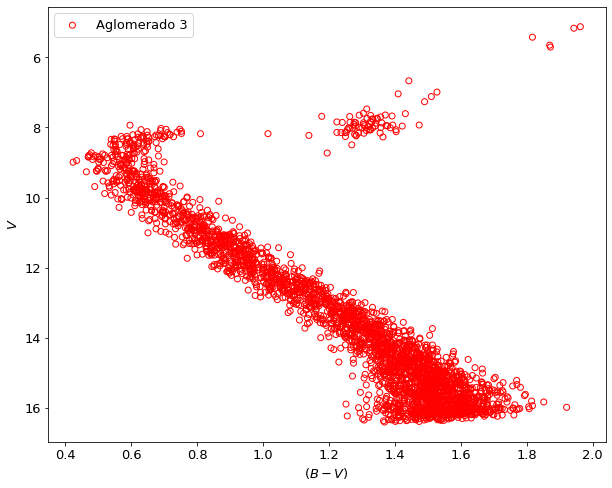

In [13]:
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

fig,ax = plt.subplots(figsize=(10,8)) #(figsize=(7,5))
plt.gca().invert_yaxis()
#plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] +5*np.log10(d3/10)+3.1*E , label = 'Isócrona', color = 'black', zorder = 10)
plt.scatter(i3['B-V'] ,i3['V'], label = 'Aglomerado 3', color = 'none', edgecolor = 'red')
plt.legend(frameon=True)
plt.xlabel(r"$(B-V)$")
plt.ylabel(r"$V$")

In [25]:
def jpt(X,Y):
    array = (X - Y)  
    array = np.sum(array**2, axis = 1)
    A, B = np.argpartition(array, 1)[0:2]
    return A,B


def frayn(X1,X2,X3):
    h = 2*((X3[0]-X1[0])*(X2[1]-X1[1]) - (X3[1]-X1[1])*(X2[0]-X1[0]))/np.sqrt(dist(X1,X2))
    return h**2

def dist(X,Y):
    distancia = 0
    for j in range(len(X)):
        distancia+= (X[j] - Y[j])**2
    return distancia


In [27]:
modulodist_inicial = 5*np.log10(d3/10) + E*3.1

arrays_de_incremento = np.arange(0,3.05,0.05)

subtracao_distancias = np.concatenate((-1*np.flip(arrays_de_incremento[1:]),arrays_de_incremento))
modulo_distancia = subtracao_distancias + modulodist_inicial

Yiso = np.zeros((len(modulo_distancia), len(iso3)))

for i in range(len(modulo_distancia)):
    Yiso[i] = iso3['Mv'] + modulo_distancia[i]

Xiso = np.zeros_like(Yiso)
Xiso[:] = iso3['(B-V)o'] + E

ISO = np.dstack((Xiso,Yiso))
ISO = np.unique(ISO,axis=1)

Xaglo = i3['B-V'] 
Yaglo = i3['V']
AGLO = np.vstack((Xaglo,Yaglo)).T

chisquared = np.zeros_like(modulo_distancia)
Beauchamp = np.zeros_like(modulo_distancia)

start = time.time()
for i in range(len(ISO)):
    for j in range(len(AGLO)):
        C,D = jpt(AGLO[j],ISO[i])
        final = frayn(ISO[i][C], ISO[i][D],AGLO[j])
        chisquared[i] += final
        Beauchamp[i] += final*10**(-0.4*AGLO[j][1])

end = time.time()
print('Tempo decorrido: ', end-start)

Tempo decorrido:  8.648274421691895


Text(0.5, 0.98, 'Aglomerado 3 ')

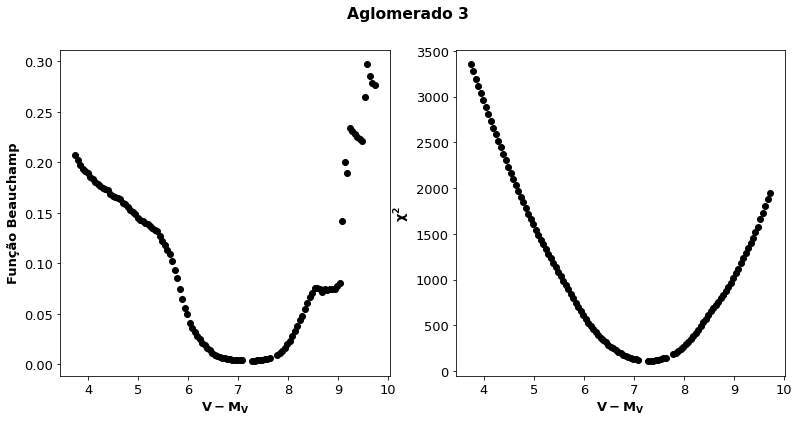

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (13,6))
ax1.scatter(modulo_distancia, Beauchamp, color = 'k')
ax2.scatter(modulo_distancia, chisquared, color = 'k')
ax1.set_xlabel(r'$ \mathbf{V - M_V}$')
ax2.set_xlabel(r'$ \mathbf{V - M_V}$')
ax1.set_ylabel('Função Beauchamp', fontweight = 'bold')
ax2.set_ylabel(r'$ \mathbf{\chi^2}$')

fig.suptitle('Aglomerado 3 ', fontweight = 'bold')


In [17]:
beau = np.where(Beauchamp==min(Beauchamp))[0]
noweight = np.where(chisquared==min(chisquared))[0] ## Definindo os valores onde a funcao definida é mínima

In [18]:
observado = 7 #V-Mv

minimo_beau = modulo_distancia[beau]
minimo_chi = modulo_distancia[noweight]
minimo_chi,minimo_beau

(array([7.28523322]), array([7.28523322]))

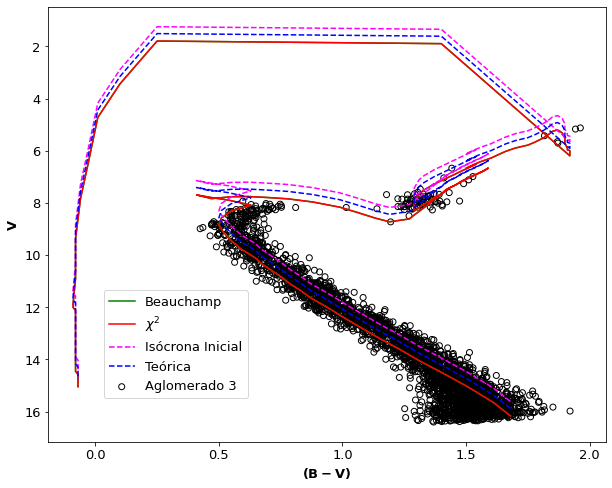

In [19]:
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

fig,ax = plt.subplots(figsize=(10,8)) #(figsize=(10,8))
plt.gca().invert_yaxis()
plt.plot(iso3['(B-V)o'] + E, iso3['Mv'] + minimo_beau , label = 'Beauchamp', color = 'green', zorder = 10)
plt.plot(iso3['(B-V)o'] + E, iso3['Mv'] + minimo_chi , label = r'$ \chi^2 $', color = 'red', zorder = 10)  
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + modulodist_inicial , '--', label = 'Isócrona Inicial', color = 'magenta', zorder = 10)
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + observado , '--', label = 'Teórica', color = 'blue', zorder = 10)
plt.scatter(i3['B-V'] ,i3['V'], label = 'Aglomerado 3', color = 'none', edgecolor = 'black')
plt.legend(frameon=True, loc = [0.1,0.1])
plt.xlabel(r"$ \mathbf{(B-V)}$")
plt.ylabel(r"$ \mathbf{V}$");


In [29]:
BeauchampAGES = np.zeros_like(age)
chisquaredAGES = np.zeros_like(age)

start = time.time()
for j in range(len(age)):
    data = iso[iso['log(Age)'] == age[j]]
    Xiso = np.array(data['(B-V)o'] + E)
    Yiso = np.array(data['Mv'] + minimo_chi)
    ISO = (np.vstack((Xiso,Yiso)).T)
    ISO = np.unique(ISO, axis=0)
    for i in range(len(AGLO)):
        C,D = jpt(AGLO[i],ISO)
        final = frayn(ISO[C], ISO[D],AGLO[i])
        chisquaredAGES[j] += final
        BeauchampAGES[j] += final*10**(-0.4*AGLO[i][1])
end = time.time()
print('Tempo decorrido: ', end-start)

Tempo decorrido:  3.1958723068237305


Text(0.5, 0.98, 'Aglomerado 3')

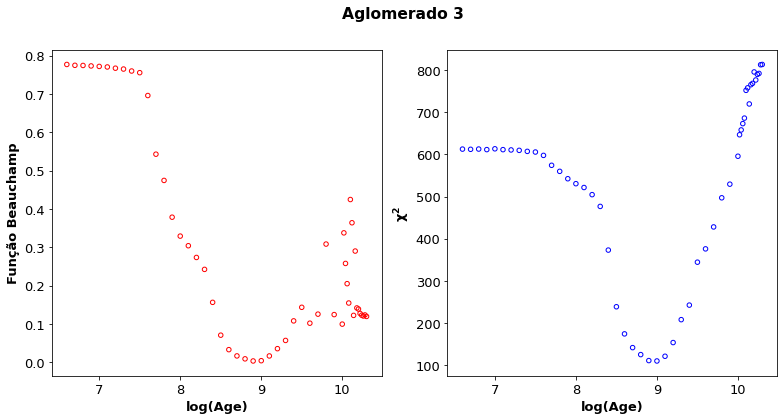

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (13,6))
ax1.scatter(age, BeauchampAGES, color = 'none', edgecolor = 'red', s = 20)
ax2.scatter(age, chisquaredAGES, color = 'none', edgecolor = 'blue', s = 20)
ax1.set_xlabel('log(Age)',  fontweight = 'bold')
ax2.set_xlabel('log(Age)',  fontweight = 'bold')
ax1.set_ylabel('Função Beauchamp',  fontweight = 'bold')
ax2.set_ylabel(r'$ \mathbf{\chi^2}$')
fig.suptitle('Aglomerado 3', fontweight = 'bold')

#from google.colab import files
#plt.savefig('aglomerado1chiAGES.png', format = 'png')
#files.download('aglomerado1chiAGES.png') 

In [22]:
newage = age[8:35]
newage

array([10.14, 10.12, 10.1 , 10.08, 10.06, 10.04, 10.02, 10.  ,  9.9 ,
        9.8 ,  9.7 ,  9.6 ,  9.5 ,  9.4 ,  9.3 ,  9.2 ,  9.1 ,  9.  ,
        8.9 ,  8.8 ,  8.7 ,  8.6 ,  8.5 ,  8.4 ,  8.3 ,  8.2 ,  8.1 ])

In [31]:
def chi_to_age(IDADE):
  data = iso[iso['log(Age)'] == IDADE]
  Yiso = np.zeros((len(modulo_distancia), len(data)))
  for k in range(len(modulo_distancia)):
    Yiso[k] = data['Mv'] + modulo_distancia[k]
  Xiso = np.zeros_like(Yiso)
  Xiso[:] = data['(B-V)o'] + E
  ISO = np.dstack((Xiso,Yiso))
  ISO = np.unique(ISO,axis=1)
  A = np.zeros(len(ISO))
  B = np.zeros(len(ISO))
  for i in range(len(ISO)):
    for j in range(len(AGLO)):
      C,D = jpt(AGLO[j],ISO[i])
      final = frayn(ISO[i][C], ISO[i][D],AGLO[j])
      A[i] += final
      #B[i] += final*10**(-0.4*AGLO[j][1])
  return A

In [32]:
start = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
  results = executor.map(chi_to_age,newage)
end = time.time()

resultado = []
for i in results:
    resultado.append(i)
print(end-start)

60.521892070770264


In [ ]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid

z = resultado
x = modulo_distancia
y = newage

# Set colomap
cmap = cm.get_cmap('jet')
cmap = cm.jet

fig,ax = plt.subplots(figsize=(8,6)) #(figsize=(10,8))
levels = len(modulo_distancia)
im  = ax.contourf(x, y, z, levels= levels, antialiased=False, cmap=cmap)


cbar = fig.colorbar(im)
cbar.set_label(r'$ \mathbf{\chi^2}$', fontweight = 'bold', rotation=0, labelpad=15)
ax.set_xlabel(r'$ \mathbf{V - M_V}$', fontweight = 'bold', labelpad=10)
ax.set_ylabel('log(Age)', fontweight = 'bold', labelpad=10)
ax.set_title('Aglomerado 3', fontweight = 'bold')
#plt.savefig('ag3_colourfill_teste_chi.png', format = 'png')

In [ ]:
Xaglo = i3['B-V'] 
Yaglo = i3['V']
AGLO = np.vstack((Xaglo,Yaglo)).T

Beauchamp_n_ages = np.zeros((len(newage),len(modulo_distancia)))
chisquared_n_ages = np.zeros((len(newage),len(modulo_distancia)))

start = time.time()
for w in range(len(newage)):
    data = iso[iso['log(Age)'] == newage[w]]
    Yiso = np.zeros((len(modulo_distancia), len(data)))
    for k in range(len(modulo_distancia)):
        Yiso[k] = data['Mv'] + modulo_distancia[k]
    Xiso = np.zeros_like(Yiso)
    Xiso[:] = data['(B-V)o'] + E
    ISO = np.dstack((Xiso,Yiso))
    #ISO = np.unique(ISO,axis=1)
    chisquared = np.zeros_like(modulo_distancia)
    Beauchamp = np.zeros_like(modulo_distancia)
    for i in range(len(ISO)):
        for j in range(len(AGLO)):
            C,D = jpt(AGLO[j],ISO[i])
            final = frayn(ISO[i][C], ISO[i][D],AGLO[j])
            chisquared_n_ages[w][i] += final
            Beauchamp_n_ages[w][i] += final*10**(-0.4*AGLO[j][1])

end = time.time()
print('Tempo decorrido: ', end-start)
